<center>
<h1>Intro Tutorial on GANs</h1>
Fermilab - March 21, 2018
</center>

This tutorial is based on Yunjey Choi's tutorials available here: https://github.com/yunjey/pytorch-tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<p>In this tutorial, we will be using: <img src="https://cdn-images-1.medium.com/max/1200/1*jcZLpgh3gppeFFgcpFSP0w.jpeg" width="300" align="top">

 > a deep learning framework that puts Python first.

<div align="center">- http://pytorch.org/</div>

Follow the instructions on the [PyTorch website](http://pytorch.org/) to install.

In [2]:
import torch
from torchvision import datasets, transforms

In [3]:
torch.__version__

'0.3.1'

`torchvision` comes with many standard machine learning datasets that are perfect to get started. To avoid spending half of our time on data wrangling, we'll use one of these, specifically, the *FashionMNIST* dataset [[arxiv:1708.07747](https://arxiv.org/abs/1708.07747)]. 

**Note**:
If afterwards you want to play around with a HEP dataset, feel free to try out the jet-images dataset our group produced for our LAGAN work [[Comput Softw Big Sci (2017) 1: 4](https://link.springer.com/article/10.1007/s41781-017-0004-6)]:

[![DOI](https://zenodo.org/badge/DOI/10.17632/4r4v785rgx.1.svg)](https://doi.org/10.17632/4r4v785rgx.1)
<a href="https://zenodo.org/record/269622#.WgZFPRNSyRs"><img src="https://github.com/YaleATLAS/CERNDeepLearningTutorial/raw/master/images/zenodo.jpg"></a>

In that case, you'd have to create your own custom dataset class that inherits from the abstract PyTorch `Dataset` class. All custom datasets should subclass it, and override `__len__`, that provides the size of the dataset, and `__getitem__`, supporting integer indexing in range from `0` to `len(self)` exclusive.

Anyways, back to *FashionMNIST*...

In [ ]:
datasets.

In [ ]:
datasets.FashionMNIST?

`torchvision` already provides us with most transformations we might want to apply to our images, and a way to compose them into a sequence of operations.

In [4]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x : 2 * x - 1) # normalize to be in [-1, 1]
            ])

In [5]:
dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

## Data Inspection

In analogy with the <a href="http://yann.lecun.com/exdb/mnist/">MNIST dataset of handwritten digits</a>, the *FashionMNIST* dataset is a 10-class grayscale image dataset, where each class corresponds to a type of fashion item.

In [6]:
# check that there exist 10 different classes
np.unique(dataset.train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

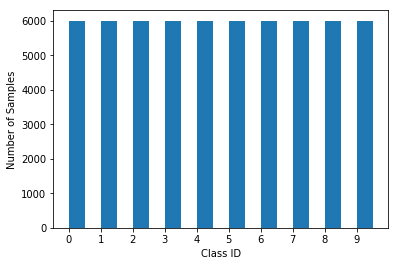

In [7]:
# check class proportions
plt.hist(dataset.train_labels,
         bins=np.linspace(0, 9.5, 20))

_ = plt.xticks(range(10))
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.show()

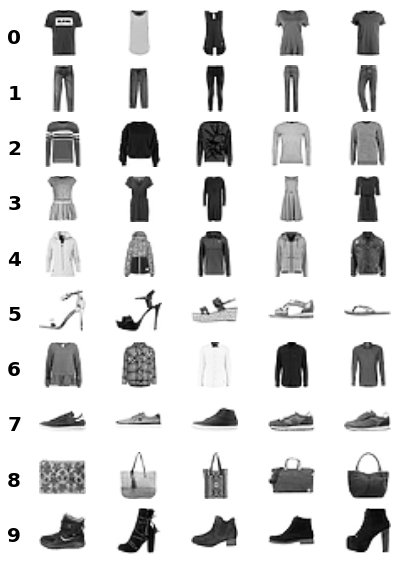

In [8]:
# plot 5 examples from each class
n_images = 5

f, axarr = plt.subplots(len(np.unique(dataset.train_labels)), n_images, figsize=(10, 10))
f.subplots_adjust(wspace=-0.7)

for n_class in np.unique(dataset.train_labels):
    # annotate axis with class
    axarr[n_class, 0].text(-20, 20, str(n_class), size=20, weight='bold')
    # plot 5 images
    for n_img, image in enumerate(dataset.train_data.numpy()[dataset.train_labels.numpy() == n_class][:n_images]):
        axarr[n_class, n_img].imshow(image, interpolation='bilinear', cmap='Greys')
        axarr[n_class, n_img].axis('off')
        

## PyTorch DataLoader

PyTorch takes care of lots of data handling for you through the convenient `DataLoader` class. A `DataLoader` allows you to iterate through your dataset and yield batches from it with a few niceties attached.

<img src="./images/dataloader.jpg">

In [9]:
BATCH_SIZE = 100
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True,
                                          num_workers=3)
# pin_memory if you're on GPU

In [10]:
n_batches = int(np.ceil(len(dataset)/ BATCH_SIZE)) # 60000 / 100

## Model Design

`torch.nn` contains all the ingredients to start building your networks. 

PyTorch is still in beta, so there are no well-defined best practices and lots of ways of doing the same thing, some that are safer and limited in scope, and some that provide you with more flexibility, should you need it.

In [11]:
from torch import nn

`torch.nn.Sequential` is a container that allows you to specify Modules to be added to your model in the order they are passed into the constructor. Alternatively, you can also pass them as an `OrderedDict`.

In [12]:
# Discriminator
D = nn.Sequential(
    nn.Linear(28 * 28, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

# Generator 
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 28 * 28),
    nn.Tanh()
)

# if you're running on GPU, move models there
if torch.cuda.is_available():
    D.cuda()
    G.cuda()

Define your loss function and optimizer by picking from the ones already available in `torch.nn` or defining your own. Note that an optimizer is defined in terms of the network parameters that it's assigned to optimize.

In [13]:
# Define your loss function and optimizer by picking from the ones already available in `torch.nn` or defining your own
criterion = nn.BCELoss() # Or remove nn.Sigmoid() and use 
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

## Training Procedure

A `Variable` is a node in a computational graph that allows for automatic differentiation across the graph. A `Variable` wraps a PyTorch `Tensor`, though the two concepts will soon be unified. `x.data` gives you access to the `Tensor` wrapped by the `Variable x`.

In [14]:
from torch.autograd import Variable

def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [15]:
import torch.nn.functional as F
from torchvision.utils import save_image

def denorm(x):
    # convert back from [-1, 1] to [0, 1]
    out = (x + 1) / 2
    return out #out.clamp(0, 1)

PyTorch allows you to build **dynamic graphs** in a very intuitive and pythonic way. 

You should write the training loop yourself, looping through the epochs and the batches.

Although this adds additional boilerplate and room for error when compared to libraries like Keras, this dynamic construction gives the flexibility required for exotic train loops that do not fit the `model.fit(...)` paradigm, such as GANs.

In [16]:
N_EPOCHS = 200

try: # allow for manual keyboard interrupt
    # loop through epochs
    for epoch in range(N_EPOCHS):
        # loop through batches (no need for class labels right now)
        for batch_number, (images, _) in enumerate(data_loader): 

            # Reshape training dataset images from (batch_size, 28, 28) to (batch_size, 28*28) for 
            # processing through fully-connected net 
            batch_size = images.shape[0] # this specific batch size (last one may not be equal to BATCH_SIZE)
            images = to_var(images.view(batch_size, -1))

            # Create targets for the discriminator network D
            # (can use label flipping or label smoothing)
            real_labels = to_var(torch.ones(batch_size, 1)) 
            fake_labels = to_var(torch.zeros(batch_size, 1))

            # 1) TRAIN DISCRIMINATOR
            # Evaluate the discriminator on the real input images
            outputs = D(images) # or D(add_instance_noise(images))
            real_score = outputs
            # Compute the discriminator loss with respect to the real labels (1s)
            d_loss_real = criterion(outputs, real_labels)

            # Draw random 64-dimensional noise vectors as inputs to the generator network
            z = to_var(torch.randn(batch_size, 64)) # the latents space is 64D
            # Transform the noise through the generator network to get synthetic images
            fake_images = G(z)
            # Evaluate the discriminator on the fake images
            outputs = D(fake_images) # or D(add_instance_noise(fake_images))
            fake_score = outputs
            # Compute the discriminator loss with respect to the fake labels (0s)
            d_loss_fake = criterion(outputs, fake_labels)

            # Backprop + Optimize the discriminator
            d_loss = d_loss_real + d_loss_fake
            D.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # 2) TRAIN GENERATOR
            # Draw random 64-dimensional noise vectors as inputs to the generator network
            z = to_var(torch.randn(batch_size, 64))
            # Transform the noise through the generator network to get synthetic images
            fake_images = G(z)
            # Evaluate the (new) discriminator on the fake images
            outputs = D(fake_images)

            # Compute the cross-entropy loss with "real" as target (1s). This is what the G wants to do
            g_loss = criterion(outputs, real_labels)

            # Backprop + Optimize the generator
            D.zero_grad() # probably unnecessary?
            G.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            if (batch_number + 1) % 300 == 0:
                print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                      'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                      %(epoch,
                        N_EPOCHS,
                        batch_number + 1,
                        n_batches,
                        d_loss.data[0],
                        g_loss.data[0],
                        real_score.data.mean(),
                        fake_score.data.mean())
                )

        # Save real images once
        if (epoch + 1) == 1:
            images = images.view(images.size(0), 1, 28, 28) # reshape
            save_image(denorm(images.data), './data/real_images.png')

        # Save sampled images
        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28) #reshape
        save_image(denorm(fake_images.data), './data/fake_images-%0.3d.png' %(epoch + 1))
        
        # Save the trained parameters 
        torch.save(G.state_dict(), './weights/generator-%0.3d.pkl' %(epoch + 1))
        torch.save(D.state_dict(), './weights/discriminator-%0.3d.pkl' %(epoch + 1))
        
except KeyboardInterrupt:
    print 'Training ended early.'

Epoch [0/200], Step[300/600], d_loss: 0.1105, g_loss: 4.4878, Mean D(x): 0.99, Mean D(G(z)): 0.09
Epoch [0/200], Step[600/600], d_loss: 0.1144, g_loss: 4.6404, Mean D(x): 0.95, Mean D(G(z)): 0.04
Epoch [1/200], Step[300/600], d_loss: 0.2611, g_loss: 6.1070, Mean D(x): 0.94, Mean D(G(z)): 0.11
Epoch [1/200], Step[600/600], d_loss: 0.3744, g_loss: 4.8863, Mean D(x): 0.92, Mean D(G(z)): 0.09
Epoch [2/200], Step[300/600], d_loss: 0.3830, g_loss: 4.2720, Mean D(x): 0.89, Mean D(G(z)): 0.11
Epoch [2/200], Step[600/600], d_loss: 0.3536, g_loss: 3.7670, Mean D(x): 0.88, Mean D(G(z)): 0.06
Epoch [3/200], Step[300/600], d_loss: 0.1885, g_loss: 3.2816, Mean D(x): 0.95, Mean D(G(z)): 0.10
Epoch [3/200], Step[600/600], d_loss: 0.1085, g_loss: 4.2594, Mean D(x): 0.96, Mean D(G(z)): 0.03
Epoch [4/200], Step[300/600], d_loss: 0.4417, g_loss: 4.4120, Mean D(x): 0.87, Mean D(G(z)): 0.09
Epoch [4/200], Step[600/600], d_loss: 0.2567, g_loss: 3.1330, Mean D(x): 0.96, Mean D(G(z)): 0.10
Epoch [5/200], Step[

## Evaluation

Load back the weights from your favorite epoch.

In [32]:
G.load_state_dict(torch.load('./weights/generator-final.pkl'))
D.load_state_dict(torch.load('./weights/discriminator-final.pkl'))

<IPython.core.display.Javascript object>


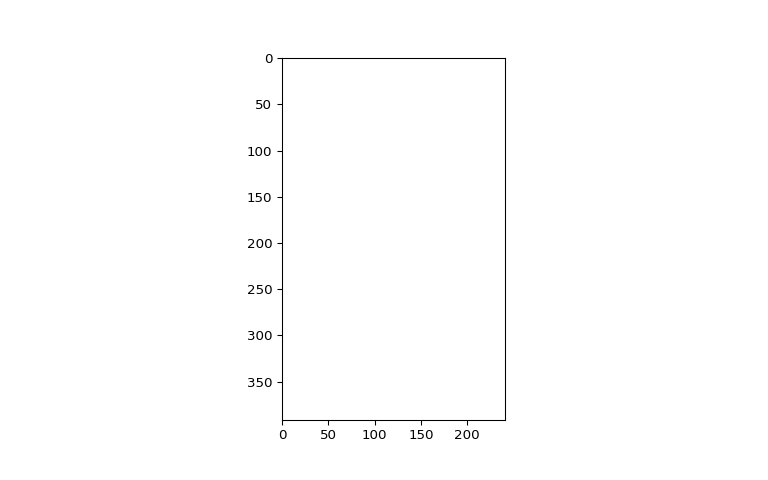

In [36]:
import glob
import matplotlib.animation as animation
import matplotlib.image as mpimg
%matplotlib notebook

fig = plt.figure(figsize=(8, 5))
ims = []
for path in glob.glob('data/fake_images-*.png')[::20]:
    imread = mpimg.imread(path)
    im = plt.imshow(imread, animated=True)
    ims.append([im])
#     print path
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)
plt.show()
ani.save('dynamic_images.mp4')

In [37]:
%matplotlib inline

In [38]:
z = to_var(torch.randn(60000, 64))
fake_images = G(z).data.numpy().reshape(60000, 28, 28)

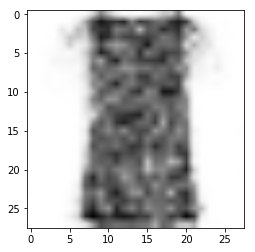

In [42]:
plt.imshow(fake_images[1], cmap='Greys', interpolation='bilinear')

In [43]:
from sklearn.cluster import MiniBatchKMeans, DBSCAN

In [44]:
inertia = []
normed_real_images = dataset.train_data.numpy().reshape(len(dataset), -1) / 255. * 2. - 1.
for n_clusters in range(2, 15):
    model = MiniBatchKMeans(n_clusters=n_clusters)
    model.fit(normed_real_images)
    inertia.append(model.inertia_)

In [45]:
from sklearn.cluster import MiniBatchKMeans
inertia_gan = []
for n_clusters in range(2, 15):
    model = MiniBatchKMeans(n_clusters=n_clusters)
    model.fit(fake_images.reshape(60000, -1))
    inertia_gan.append(model.inertia_)

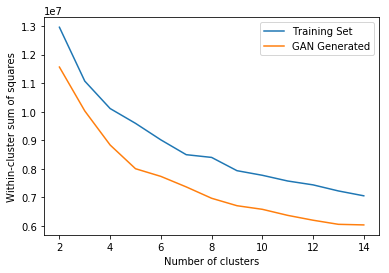

In [46]:
plt.plot(range(2, 15), inertia, label='Training Set')
plt.plot(range(2, 15), inertia_gan, label='GAN Generated')
plt.legend()
plt.ylabel('Within-cluster sum of squares')
plt.xlabel('Number of clusters')

## Tricks

In [137]:
def add_instance_noise(images, std=0.1):
    '''
    add normal noise to images
    '''
    noise = Variable(std * torch.randn(images.shape))
    return images + noise

In [124]:
def label_flip(x, p=0.05):
    '''
    bit flip with some probability
    Args:
    ----
        x = torch.FloatTensor
        p = float, probability of flip
    Returns:
    --------
        x_new = torch.FloatTensor
    '''
    x_new = x.clone()
    selection = torch.rand(x_new.shape) < prob
    x_new[selection] = (x_new[selection].type(torch.ByteTensor)^1).type(torch.FloatTensor)
    return x_new

In [125]:
def label_smoothe(x, p=0.05, smoothing_param=0.3):
    '''
    label smoothing with some probability
    Args:
    ----
        x = torch.FloatTensor
        p = float, probability of an entry being selected for smoothing
        smoothing_param = float, max amount of variation
    Returns:
    --------
        x_new = torch.FloatTensor
    '''
    x_new = x.clone()
    selection = torch.rand(x_new.shape) < prob
    smoothing = torch.rand(selection.sum()) * smoothing_param
    x_new[selection] = torch.abs(x_new[selection] - smoothing)
    return x_new

## Wasserstein GAN

In [47]:
# Critic
# Note that we just have a linear output here
critic = nn.Sequential(
    nn.Linear(28 * 28, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1)
)

# Generator 
generator = nn.Sequential(
    nn.Linear(64, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 28 * 28),
    nn.Tanh()
)

# if you're running on GPU, move models there
if torch.cuda.is_available():
    critic.cuda()
    generator.cuda()

In [48]:
# These are the recommended defaults (sauf N_EPOCHS) from the WGAN paper.
LR = 0.00005
N_EPOCHS = 300
N_CRITIC_STEPS = 5
CLAMP = 0.01

In [232]:
critic_optimizer = torch.optim.RMSprop(critic.parameters(), lr=LR)
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=LR)

For the training loop, we want to alternate between `N_CRITIC_STEPS` critic updates and a single generator update. We'll keep a counter that will help us know where we are.

In [ ]:
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        
        # Keep track of what critic step we're on
        crit_steps = 0
        
        # loop through batches (no need for class labels right now)
        for batch_number, (images, _) in enumerate(data_loader): 
            
            # this specific batch size (last one may not be equal to BATCH_SIZE)
            batch_size = images.shape[0] 
            
            # Reshape training dataset images from (batch_size, 28, 28) to (batch_size, 28*28) for 
            # processing through fully-connected net 
            images = to_var(images.view(batch_size, -1))

            # 1) TRAIN CRITIC
            # If we haven't done enough steps, let's train the critic
            if crit_steps < N_CRITIC_STEPS:
                critic.zero_grad()
                generator.zero_grad()
        
                # clamp parameters to a cube
                for p in critic.parameters():
                    p.data.clamp_(-CLAMP, CLAMP)

                # Accum grads with real images (we want the critic to output a high value here)
                err_real = torch.mean(critic(images))
            
                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (we want the critic to output a low value here)
                err_fake = torch.mean(critic(fake_images)) 
                
                # If we minimize this, we maximize err_real - err_fake
                critic_loss = err_fake - err_real
                critic_loss.backward()
                critic_optimizer.step()
                
                # We increment our counter now that we've seen a critic update
                crit_steps += 1
            # 2) TRAIN GENERATOR
            # Here we have done N_CRITIC_STEPS critic updates, so we do the generator now
            else:
                critic.zero_grad()
                generator.zero_grad()

                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (generator wants the critic to 
                # output a high value here, "tricking" it)
                outputs = critic(fake_images)
                
                # We minimize this so we maximize the quantity we actually care about
                generator_loss = -torch.mean(outputs)

                # Backprop + Optimize the generator
                generator_loss.backward()
                generator_optimizer.step()
                
                # Reset the counter - the next batch will go to the critic!
                crit_steps = 0

                if (batch_number + 1) % 300 == 0:
                    print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                          'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                          %(epoch,
                            N_EPOCHS,
                            batch_number + 1,
                            n_batches,
                            critic_loss.data[0],
                            generator_loss.data[0],
                            err_real.data.mean(),
                            err_fake.data.mean())
                    )

        # Save real images once
        if (epoch + 1) == 1:
            images = images.view(images.size(0), 1, 28, 28) # reshape
            save_image(denorm(images.data), './data/wgan_real_images.png')

        # Save sampled images
        # Save sampled images
        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28) #reshape
        save_image(denorm(fake_images.data), './data/wgan_fake_images-%0.3d.png' %(epoch + 1))

        # Save the trained parameters 
        torch.save(generator.state_dict(), './weights/wgan_generator-%0.3d.pkl' %(epoch + 1))
        torch.save(critic.state_dict(), './weights/wgan_discriminator-%0.3d.pkl' %(epoch + 1))
        
except KeyboardInterrupt:
    print 'Training ended early.'

Epoch [0/300], Step[300/600], d_loss: -0.6322, g_loss: -3.9509, Mean D(x): 4.57, Mean D(G(z)): 3.94
Epoch [0/300], Step[600/600], d_loss: -0.2779, g_loss: -3.9530, Mean D(x): 4.19, Mean D(G(z)): 3.92
Epoch [1/300], Step[300/600], d_loss: -0.2292, g_loss: -1.7990, Mean D(x): 2.07, Mean D(G(z)): 1.84
Epoch [1/300], Step[600/600], d_loss: -1.5612, g_loss: -0.1435, Mean D(x): 1.74, Mean D(G(z)): 0.18
Epoch [2/300], Step[300/600], d_loss: -2.7454, g_loss: -1.2273, Mean D(x): 3.98, Mean D(G(z)): 1.23
Epoch [2/300], Step[600/600], d_loss: -2.7234, g_loss: -0.5947, Mean D(x): 3.29, Mean D(G(z)): 0.57
Epoch [3/300], Step[300/600], d_loss: -2.8666, g_loss: -0.5841, Mean D(x): 3.45, Mean D(G(z)): 0.59
Epoch [3/300], Step[600/600], d_loss: -2.2584, g_loss: -1.1946, Mean D(x): 3.50, Mean D(G(z)): 1.24
Epoch [4/300], Step[300/600], d_loss: -0.9818, g_loss: -1.7472, Mean D(x): 2.76, Mean D(G(z)): 1.77
Epoch [4/300], Step[600/600], d_loss: -2.5473, g_loss: 0.7313, Mean D(x): 1.86, Mean D(G(z)): -0.69


In [49]:
# Load back saved weights (we have these pre-trained)
generator.load_state_dict(torch.load('./weights/wgan_generator-final.pkl'))
critic.load_state_dict(torch.load('./weights/wgan_discriminator-final.pkl'))

In [50]:
NB_SAMPLES = 400
z = to_var(torch.randn(NB_SAMPLES, 64))
fake_images = generator(z)

In [51]:
save_image(denorm(fake_images.view(fake_images.size(0), 1, 28, 28).data), # reshape
           './data/wgan_fake_images_final.png', nrow=20)

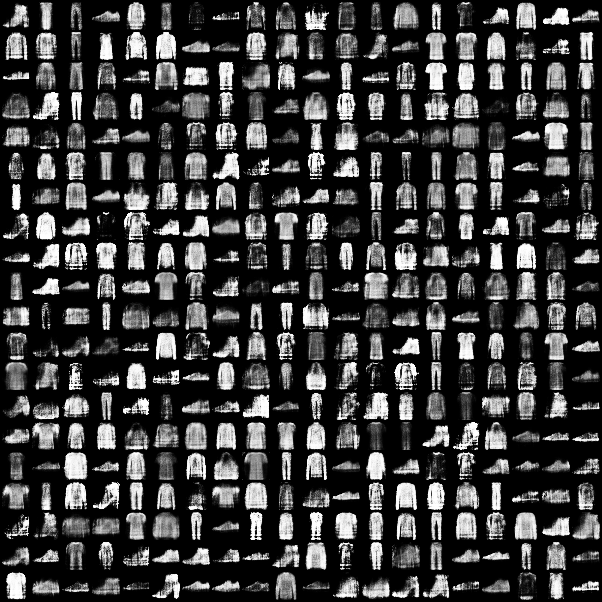

In [52]:
import IPython
IPython.display.Image('./data/wgan_fake_images_final.png')

In [53]:
NB_SAMPLES = 60000
z = to_var(torch.randn(NB_SAMPLES, 64))
fake_images = generator(z)

In [55]:
from sklearn.cluster import MiniBatchKMeans
inertia_wgan = []
for n_clusters in range(2, 15):
    model = MiniBatchKMeans(n_clusters=n_clusters)
    model.fit(fake_images.data.numpy().reshape(60000, -1))
    inertia_wgan.append(model.inertia_)

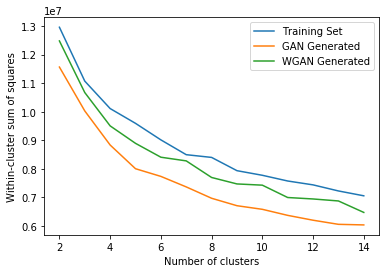

In [56]:
plt.plot(range(2, 15), inertia, label='Training Set')
plt.plot(range(2, 15), inertia_gan, label='GAN Generated')
plt.plot(range(2, 15), inertia_wgan, label='WGAN Generated')
plt.legend()
plt.ylabel('Within-cluster sum of squares')
plt.xlabel('Number of clusters')